# Tutorial 5
## Outline
* Auto-differentiation frameworks: tensorflow and pytorch
* Nomenclatures and general components of training a NN
* PyTorch Tensors
* Building an NN with pytorch


## Tenserflow vs PyTorch

* PyTorch is developed by Facebook
* TensorFlow is developed by Google. Keras is a front-end API of TensorFlow.

### Similarities
* Both are auto-differentiation framework
* Both are open source
* Both support CPU and GPU executions
* Both have a large and active community

### Dissimilarities
#### Graph structure
* Depending on version, TensorFlow is either static graph (version 1) or dynamic graph (version 2, with eager execution), but not as efficient as static graph
* PyTorch is completely dynamic graph, and is efficient (sometimes even more efficient than TF with static graph!)


#### Language support
* TensorFlow supports a large variety of languages, i.e. C++, JavaScript, Python, C#, Ruby, and Swift.
* PyTorch only supports python

#### Deployment
* Tensorflow can be easily deployed into different platforms, including mobile devices!
* PyTorch code has to be converted into a different framework for depolyment

### General suggestions
* TensorFlow (with Keras) is easier to use for trying out existing models on a new dataset with minimal modifications on the architecture
* It is also good for building simple models, like MLP networks 
* PyTorch is more useful in research, when you would like to try complicated NN architectures and needs to do a lot of debuggingg and validation of ideas, but do not care about deployment

## Nomenclatures and general components of training a NN
* **Epoch**: Going through training data once
* **Batch**: Set of data for calculating each gradient update
* **Batch size**: Size of data in a batch
* **Iteration**: One iteration = one gradient update
* **Learning rate**: Coefficient multiplied to the gradient in each update

### Neural network architecture
* Multiple layer perceptron (MLP)
* Convolutional neural network (CNN)
* Graph convolutional neural network (GCN)
* Recurrent neural network (RNN)
* AutoEncoder (AE) 
* Attention mechanism / Transformer 
* ...

### Optimizer
* SGD (SGDM)
* Adam
* RMSProp
* ...

### Loss function
* Mean squared error (MSE)
* Mean absolute error (MAE)
* Cosine similarity 
* Binary crossentropy (CE) 
* Categorical crossentropy
* ...

## PyTorch: Tensors

Here we introduce the most fundamental PyTorch concept: the **Tensor**. A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Behind the scenes, Tensors can keep track of a computational graph and gradients, but they’re also useful as a generic tool for scientific computing.

In [9]:
import torch
import numpy as np

a = torch.tensor([[0.1, 1.2], [2.2, 3.1], [4.9, 5.2]])
a.size()

torch.Size([3, 2])

In [10]:
a.reshape(-1)

tensor([0.1000, 1.2000, 2.2000, 3.1000, 4.9000, 5.2000])

Convert numpy array to torch and vice versa

In [4]:
a = np.ones((3,2))
type(a)

numpy.ndarray

In [5]:
b = torch.tensor(a, dtype = torch.int)
b

tensor([[1, 1],
        [1, 1],
        [1, 1]], dtype=torch.int32)

In [7]:
b.detach().numpy()

array([[1, 1],
       [1, 1],
       [1, 1]], dtype=int32)

Specify the device and data types for torch tensors

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
a = torch.randn((2,3), device=device, dtype=dtype)

In [12]:
a.to(torch.device("cpu"))

tensor([[-0.7555, -0.0454, -1.2166],
        [ 0.4127,  0.1400,  0.6012]])

## Building NN for regression task
For example, let's use a two hidden-layer MLP network [20, 15, 1] to simulate the Rosenbrock banana function!<br>
$f(x,y)=(1-x)^2+10(y-x^2)^2$<br>
$x\in[-2,2],y\in[-2,2]$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def generate_X(number):
    xs=(np.random.random(number)*2-1)*2
    ys=(np.random.random(number)*2-1)*2
    return np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)])
    
def generate_data(number,stochascity=0.05):
    X=generate_X(number)
    xs=X[:,0]
    ys=X[:,1]
    fs=(1-xs)**2+10*(ys-xs**2)**2
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)]),fs*stochastic_ratio

<IPython.core.display.Javascript object>


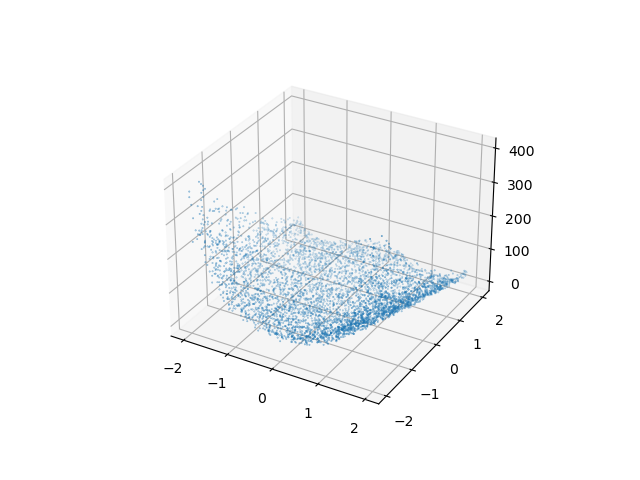

In [14]:
x, y = generate_data(5000, 0.3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], y, s=0.1)

### Building a PyTorch model

In [16]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    

In [17]:
model = MLP()
model

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [25]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

weights_best = model.state_dict()
loss_best = np.inf

for i in range(100):
    model.load_state_dict(weights_best)
    
    train_X, train_y = generate_data(128, stochascity=0.1)
    train_X = torch.tensor(train_X, dtype=torch.float)
    train_y = torch.tensor(train_y, dtype=torch.float)
    pred = model(train_X)
    loss = loss_func(pred, train_y.reshape(-1,1))
    optimizer.zero_grad() #to avoid weight explode
    
    if loss.item() < loss_best:
        loss_best = loss.item()
        weights_best = model.state_dict()
    
    loss.backward()
    optimizer.step()
    print("Iteration %d: Loss value - %.4f" % (i + 1, loss.item()))

Iteration 1: Loss value - 4834.0996
Iteration 2: Loss value - 6663.7832
Iteration 3: Loss value - 5059.6377
Iteration 4: Loss value - 6099.1577
Iteration 5: Loss value - 5909.9795
Iteration 6: Loss value - 6717.9375
Iteration 7: Loss value - 2777.8931
Iteration 8: Loss value - 3522.0452
Iteration 9: Loss value - 4712.4375
Iteration 10: Loss value - 4555.2041
Iteration 11: Loss value - 5218.2734
Iteration 12: Loss value - 6092.4019
Iteration 13: Loss value - 3119.2476
Iteration 14: Loss value - 5071.4263
Iteration 15: Loss value - 6903.0801
Iteration 16: Loss value - 4084.9795
Iteration 17: Loss value - 5273.3882
Iteration 18: Loss value - 4895.8940
Iteration 19: Loss value - 4474.8965
Iteration 20: Loss value - 4488.8159
Iteration 21: Loss value - 4410.6875
Iteration 22: Loss value - 6948.8213
Iteration 23: Loss value - 3493.9563
Iteration 24: Loss value - 3833.8169
Iteration 25: Loss value - 5533.3535
Iteration 26: Loss value - 6424.8628
Iteration 27: Loss value - 4855.1958
Iteration 

<IPython.core.display.Javascript object>


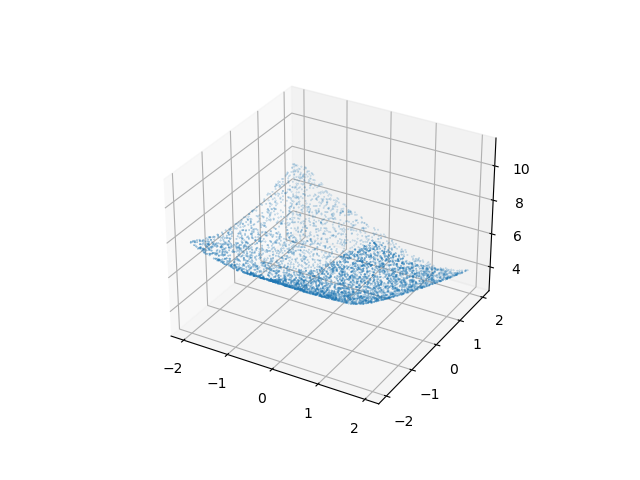

In [24]:
new_X = generate_X(5000)
with torch.no_grad():
    new_y = model(torch.tensor(new_X, dtype=torch.float))
new_y = new_y.detach().numpy()
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(new_X[:, 0], new_X[:, 1], new_y, s=0.1)